In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image


In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
epoch_num = 10
lr = 1e-3
batchsize = 32

In [ ]:
trainset = datasets.CIFAR10(root='./data',train=True, download=True, transform=transform)

testset = datasets.CIFAR10(root='./data', train=False, download=True,transform=transform)

trainloader = DataLoader(trainset, batch_size=batchsize, shuffle=True)

testloader = DataLoader(testset, batch_size=batchsize, shuffle=True)

100%|██████████| 170498071/170498071 [00:06<00:00, 26091155.54it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
def save_recon_image(img, name):
    img = img.view(img.size(0), 3, 32, 32)
    save_image(img, name)

def make_dir():
    image_dir = 'AE_Conv_CIFAR10_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=1, padding=0),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, stride=1, padding=0),           # [batch, 24, 8, 8]
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#
            nn.ConvTranspose2d(8, 8, 3, stride=1, padding=0),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 3, stride=1, padding=0),   # [batch, 3, 32, 32]
            nn.Tanh(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder()
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(1, 1))
    (3): Tanh()
  )
)


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
def train(model, trainloader, epoch_num):
    train_loss = []
    for epoch in range(epoch_num):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data
            img = img.to(device)
            optimizer.zero_grad()
            outputs = model(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch: {} , Train Loss: {:.3f}'.format(
            epoch+1, loss))
        if epoch % 10 == 0:
            save_recon_image(img.cpu().data, name='./AE_Conv_CIFAR10_Images/original{}.png'.format(epoch))
            save_recon_image(outputs.cpu().data, name='./AE_Conv_CIFAR10_Images/decoded{}.png'.format(epoch))
    return train_loss


In [ ]:
def test(model, testloader):
     for batch in testloader:
        img, _ = batch
        img = img.to(device)
        outputs = model(img)
        outputs = outputs.view(outputs.size(0), 3, 32, 32).cpu().data
        save_image(img,'original_image.png')
        save_image(outputs, 'ae_conv_cifar10_reconstruction.png')
        break

cuda:0
Epoch: 1 , Train Loss: 0.025
Epoch: 2 , Train Loss: 0.010
Epoch: 3 , Train Loss: 0.008
Epoch: 4 , Train Loss: 0.007
Epoch: 5 , Train Loss: 0.006
Epoch: 6 , Train Loss: 0.006
Epoch: 7 , Train Loss: 0.006
Epoch: 8 , Train Loss: 0.006
Epoch: 9 , Train Loss: 0.005
Epoch: 10 , Train Loss: 0.005


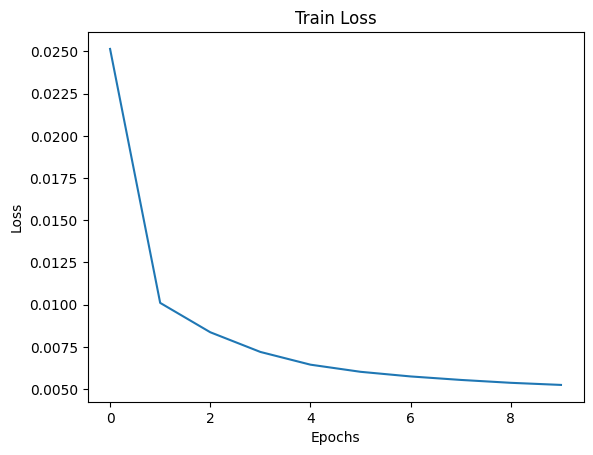

In [ ]:
device = get_device()
print(device)
model.to(device)
make_dir()
train_loss = train(model, trainloader, epoch_num)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('conv_ae_cifar10_loss.png')
test(model, testloader)